In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas



#读取数据
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
kdd_data_10percent = pandas.read_csv("kddcup.data_10_percent.csv", header=None, names = col_names)



#数据预处理：1.随机抽样
X_sample=kdd_data_10percent.sample(10000)


num_features = [
    "duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
X=X_sample[num_features].values
y = X_sample['label'].values
y[y!='normal.'] = 1
y[y=='normal.'] = 0
y=y.astype('int')

In [184]:
y.dtype

dtype('int32')

In [185]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                    test_size=0.2,random_state=1)

In [186]:
pipe_lr=Pipeline([('scl',StandardScaler()),
                   ('clf',LogisticRegression(
                       penalty='l2',random_state=0))])

Test Accuracy: 0.993
[[ 413    3]
 [  11 1573]]


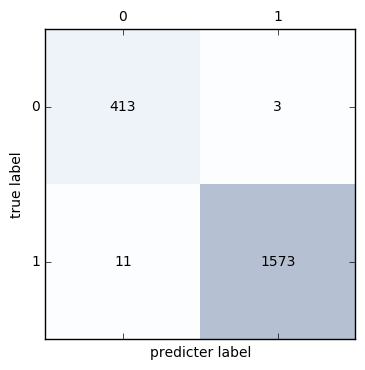

In [187]:
pipe_lr.fit(X_train,y_train)
print('Test Accuracy: %.3f' %pipe_lr.score(X_test,y_test))
#混淆矩阵
from sklearn.metrics import confusion_matrix
y_pred=pipe_lr.predict(X_test)
confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)
#画图
fig,ax=plt.subplots()
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('predicter label')
plt.ylabel('true label')
plt.show()

In [188]:
#计算ROC AUC得分
pipe_lr=pipe_lr.fit(X_train,y_train)
y_pred=pipe_lr.predict(X_test)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC:%.3f' %roc_auc_score(y_true=y_test,y_score=y_pred,
                                   ))
print('Accuracy:%.3f' %accuracy_score(y_true=y_test,y_pred=y_pred))

ROC AUC:0.993
Accuracy:0.993


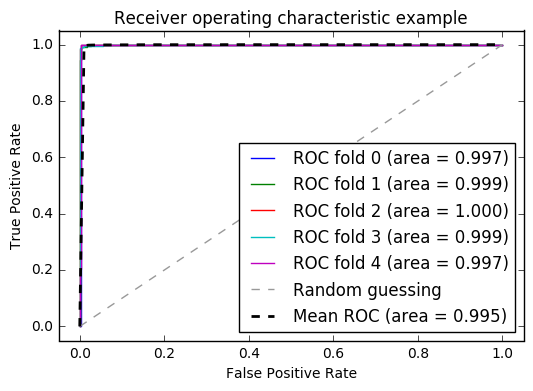

In [189]:
#使用10折交叉验证，并且画ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(y_train, n_folds=5,random_state=1)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = pipe_lr.fit(X_train[train], 
                             y_train[train]).predict_proba(X_train[test])
    #通过roc_curve()函数，求出fpr和tpr，以及阈值
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1],
                                     )
    mean_tpr += interp(mean_fpr, fpr, tpr)			#对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
    mean_tpr[0] = 0.0 								#初始处为0
    roc_auc = auc(fpr, tpr)
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

#画对角线
plt.plot([0, 1], [0, 1], '--', 
         color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv) 					#在mean_fpr100个点，每个点处插值插值多次取平均
mean_tpr[-1] = 1.0 						#坐标最后一个点为（1,1）
mean_auc = auc(mean_fpr, mean_tpr)		#计算平均AUC值
#画平均ROC曲线
#print mean_fpr,len(mean_fpr)
#print mean_tpr
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="best")
plt.show()

In [190]:
import numpy as np
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,
                                X=X_train,y=y_train,
                                train_sizes=np.linspace(0.1,1,10),
                                 cv=10, n_jobs=1)
train_mean=np.mean(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_std=np.std(train_scores,axis=1)

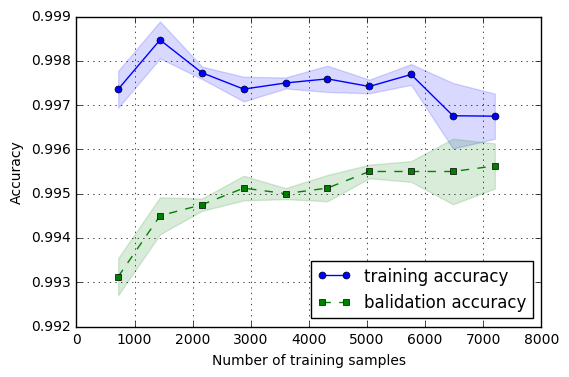

In [170]:
import matplotlib.pyplot as plt
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,
         color='blue',alpha=0.15)
plt.plot(train_sizes,test_mean,color='green',linestyle='--',
         marker='s',markersize=5,
         label='balidation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,
         color='green',alpha=0.15)
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()